# Реализованная и подразумеваемая волатильность.

## Описание:

Произведем загрузку истории котировок фьючерса на индекс РТС с экспирацией в декабре 2022 года, а также квартальных опционов колл на этот же фьючерс.

Для фьючерса рассчитаем реализованную волатильность.

Для опциона рассчитаем подразумеваемую волатильность на центральном страйке.

Выведем графики.

## Импорт библиотек:

In [1]:
import numpy as np
import pandas as pd

from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

## Настройки:

In [2]:
sns.set_theme()
pd.options.display.float_format = '{:.2f}'.format

## Константы (имеют технический характер, описание опустим)

In [3]:
N_STRIKES = 1
PATH_LOCAL_FUTURES = 'FUTURES/'
PATH_LOCAL_OPTIONS = 'OPTIONS/'
COLUMNS = ['date', 'wav_p', 'adj_price', 'open', 'high', 'low', 'close', 'chng', 'lt_vol',
           'n_trades', 'volume_rub', 'volume_contr', 'open_int_rub', 'open_int_contr']
TARGET_COLUMN_NAME = 'adj_price'
KEYS_TO_STRIKESTEPS = {'RTS': 5000}

In [4]:
RTS_calendar = {'12.22': ['151222']}

In [5]:
EXPIRATIONS_MONTHLY = {'RTS': RTS_calendar}

## Пользовательские функции и классы:

#### формула Блека - Шоулза для опциона на фьючерс

In [6]:
#-----Black- Sholes:
def d1_calc(spot, strike, sigma, T):
    result = (np.log(spot/strike) + 0.5 * (sigma ** 2) * (T)) / (sigma * np.sqrt(T))
    return result
def n_d1_calc(d1):
    result = (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * (d1 ** 2))
    return result
def premium(spot, strike, sigma, T, option_type):
    d1 = d1_calc(spot, strike, sigma, T)
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        N_d2 = norm.cdf(d2)
        delta_call = norm.cdf(d1)
        result = (spot * delta_call - strike * N_d2)
    if option_type == 'put':
        N_minus_d2 = norm.cdf(-d2)
        delta_put = (norm.cdf(d1) - 1)
        result = (strike * N_minus_d2 + spot * delta_put)
    return result

#### функция потерь необходима для подбора подразумеваемой волатильности опциона

In [7]:
def cost_func(spot, strike, T, option_type, sigma, prem):
    return premium(spot, strike, sigma, T, option_type) - prem

#### функция расчета подразумеваемой волатильности

In [8]:
def compute_iv(spot, strike, T, option_type, prem):
    left = 0.01
    right = 10
    error = 0.0000001
    while right - left > error:
        if cost_func(spot, strike, T, option_type, left, prem) == 0:
            return left
        middle = (left + right) / 2
        if cost_func(spot, strike, T, option_type, left, prem) * \
        cost_func(spot, strike, T, option_type, middle, prem) < 0:
            right = middle
        else:
            left = middle
    return left

#### функция парсинга и стандартной предобработки файла

In [9]:
def parse_csv(parse_from_,
              sep_ = ',',
              enc_ = None,
              datetime_format_ = '%Y.%m.%d',
              columns_ = None,
              set_target_ = True):
    df = pd.read_csv(parse_from_, sep = sep_, encoding = enc_)
    if columns_:
        df.columns = columns_
    df['date'] = pd.to_datetime(df['date'], format = datetime_format_)
    df = df.sort_values(by = 'date')
    df.set_index('date', inplace = True)
    if set_target_:
        df = df[[TARGET_COLUMN_NAME]]
    return df

#### класс применим для автоматизации процессов парсинга файлов, расчетов необходимых значений, а также дальнейшего упорядоченного хранения соответствующих датафреймов.

класс содержит в себе три датафрейма:
- с котировками фьючерсов (self.futures) и рассчитанных значений реализованной волатильности
- с премиями опционов с одним сроком погашения, но различными стайками
- с подразумеваемыми волатильностями опционов

кроме того класс содержит в себе ряд методов (по очередности исполнения):
- self.parse_fut() обращается к функции парсинга и сохраняет котировки фьючерса в соответствующий датафрейм
- self.calc_rv() добавляет значения реализованной волатильности к котировкам фьючерса
- self.parse_opt() обращается к функции парсинга и собирает котировки опциона с одним сроком погашения, но различными страйками в один датафрейм и сохраняет его
- self.calc_volatility_smiles() переводит котриовки опционов (премии) в подразумеваемые волатильности и сохраняет в соответствующий датафрейм, для этого обращается к методу self.get_prems_ivs(), который, в свою очередь вызывает функцию compute_iv().

In [10]:
class Jarvis:
    def __init__(self, name, fut = True, opt = True, iv = False):
        # name = 'RTS-3.23', 'Si-12.22', 'GAZR-6.19', 'SBRF-9.17'
        self.name = name
        split_ = self.name.split('-')
        # key = 'RTS', 'Si'
        self.key = split_[0]
        # date = '3.23'
        self.date = split_[1]
        split_ = self.date.split('.')
        # month = '3', '6', '9', '12'
        self.month = split_[0]
        # year = '23'
        self.year = split_[1]
        self.year_second_digit = self.year[1]
        if fut:
            self.futures = self.parse_fut()
            self.calc_rv()
        if opt:
            self.options = self.parse_opt()
        if iv:
            self.volatility_smiles = self.calc_volatility_smiles()
    # функция переносит соответствующие премии опционов из датафрейма опционов
    # в датафрейм подразумеваемых волатильностей        
    def get_prems_ivs(self, line):
        strikestep = KEYS_TO_STRIKESTEPS[self.key]
        opt = line['opt']
        date = line.name
        spot = line['spot']
        center_strike = round(line['spot'] / strikestep) * strikestep
        T = line['t'] / 365
        option_type = 'call'
        prem = self.options[opt].loc[date, center_strike]
        try:
            iv = compute_iv(spot, center_strike, T, option_type, prem) * 100
        except:
            iv = np.NaN
        line['center_strike_iv'] = iv
        return line
    # Расчет подразумеваемой волатильности
    def calc_volatility_smiles(self):
        volatility_smiles = {}
        for opt in (self.options):
            opt1 = self.options[opt]
            vs = pd.DataFrame(index = opt1.index)
            exp_date = pd.to_datetime(opt, format='%d%m%y')
            vs['t'] = (exp_date - vs.index).days
            vs['opt'] = opt
            vs = vs[vs['t'] > 0]
            vs['spot'] = self.futures[TARGET_COLUMN_NAME]
            vs = vs.apply(self.get_prems_ivs, axis=1)
            volatility_smiles[opt] = vs[
                ['t', 'center_strike_iv']
            ]
        return volatility_smiles
    # Парсим опционы на фьючерс        
    def parse_opt(self):
        options = {}
        expirations = EXPIRATIONS_MONTHLY[self.key][self.date]
        strikestep = KEYS_TO_STRIKESTEPS[self.key]
        lower = round(self.futures[TARGET_COLUMN_NAME].min() / strikestep) * strikestep
        upper = round(self.futures[TARGET_COLUMN_NAME].max() / strikestep) * strikestep
        strikes = range(lower - N_STRIKES * strikestep, upper + (N_STRIKES + 1) * strikestep, strikestep)
        for expiration in (expirations):
            df = pd.DataFrame()
            exp_day = expiration[0:2]
            exp_month = expiration[2:4]
            exp_year = expiration[4:6]
            for strike in (strikes):
                try:
                    option_name = self.name + 'M' +  expiration + 'CA' + str(strike)
                    parse_from = PATH_LOCAL_OPTIONS + self.key + '/' + option_name + '.csv'
                    option = parse_csv(parse_from_ = parse_from,
                                       sep_ = ',',
                                       enc_ = None,
                                       datetime_format_ = '%Y.%m.%d',
                                       columns_ = None,
                                       set_target_ = True)
                    option.columns = [strike]
                    df = pd.concat([df, option], axis=1)
                except:
                    print(self.name, expiration, strike, '???')
            try:
                df = df.sort_values(by = ['date'])
            except:
                print('df no sort', self.name, expiration, 'empty?')
            options[expiration] = df
        return options
    #Парсим фьючерс    
    def parse_fut(self):
        parse_from = (PATH_LOCAL_FUTURES + self.key + '/' + self.name + '.csv')
        futures = parse_csv(parse_from_ = parse_from,
                            sep_ = ',',
                            enc_ = None,
                            datetime_format_ = '%Y.%m.%d',
                            columns_ = None,
                            set_target_ = True)
        return futures
    
    #Расчет реализованной волатильности на фьючерсе
    def calc_rv(self, shift = 0):
        self.futures['ln_r'] = np.log(self.futures[TARGET_COLUMN_NAME].shift(shift).pct_change() + 1)
        self.futures['rv_20'] = self.futures['ln_r'].rolling(20).std(ddof = 1) * 100 * np.sqrt(250)

## Загрузка данных и расчет волатильностей

Загрузим котировки фьючерса и опционов, применив соответствующие методы классов будут рассчитаны реализованная волатильность фьючерса (метод .calc_rv()) и подразумеваемая волатильность на центральном страйке опциона (метод .calc_volatility_smiles())

In [11]:
j = Jarvis('RTS-12.22', fut = True, opt = True, iv = True)

Проверим результаты

Выведем информацию по датафрейму с фьючерсами

In [12]:
fut = j.futures

In [13]:
fut

,adj_price,ln_r,rv_20
date,,,
2020-12-11,130870,NaN,NaN
2020-12-14,129990,-0.01,NaN
2020-12-15,129010,-0.01,NaN
2020-12-16,131010,0.02,NaN
2020-12-17,133050,0.02,NaN
...,...,...,...
2022-12-09,109890,0.00,17.18
2022-12-12,109130,-0.01,16.86
2022-12-13,109050,-0.00,16.37


In [14]:
fut.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 510 entries, 2020-12-11 to 2022-12-15
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   adj_price  510 non-null    int64  
 1   ln_r       509 non-null    float64
 2   rv_20      490 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 32.1 KB


In [15]:
fut.isna().sum()

adj_price     0
ln_r          1
rv_20        20
dtype: int64

In [16]:
fut.index.is_monotonic

True

Построим графики цены, логарифмированной дневной доходности и реализованной волатильности

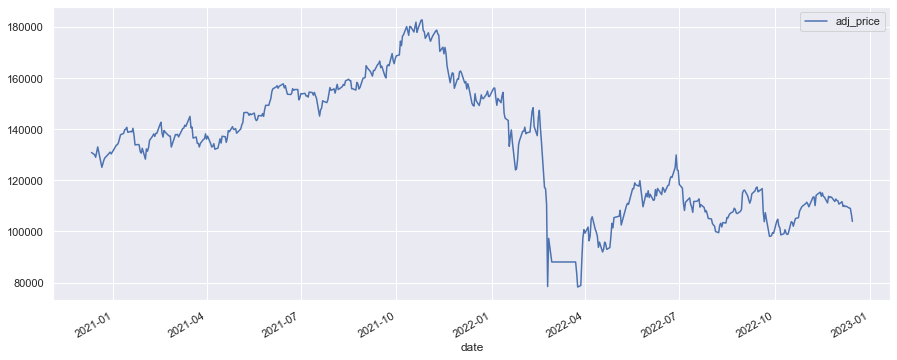

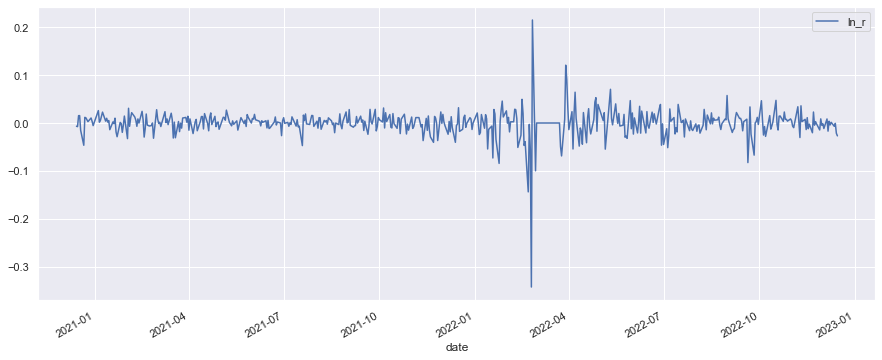

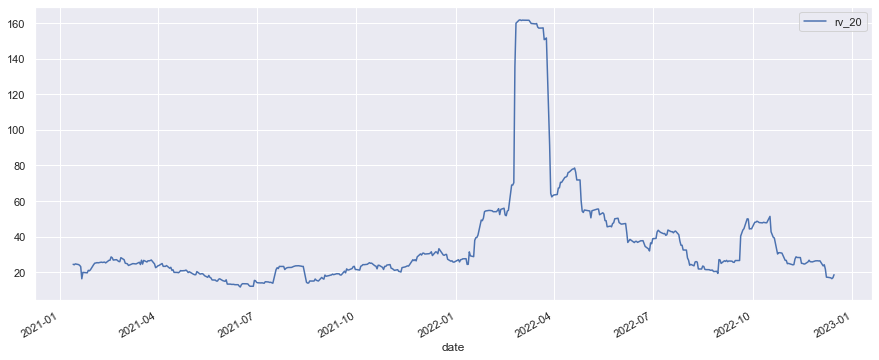

In [17]:
for col in list(fut.columns):
    fut[col]['2000':].plot(figsize = (15, 6), legend = True)
    plt.show()

Проверим датафрейм с премиями опционов

In [18]:
options = j.options['151222']

In [19]:
options

,75000,80000,85000,90000,95000,100000,105000,110000,115000,120000,...,145000,150000,155000,160000,165000,170000,175000,180000,185000,190000
date,,,,,,,,,,,,,,,,,,,,,
2021-04-21,64110.00,59740.00,55470.00,51330,47340.00,43500.00,39830.00,36340.00,33030.00,29930.00,...,17520.00,15640.00,13940.00,12410.00,11040.00,9820.00,8730.00,7770.00,6920.00,6170.00
2021-04-22,66480.00,62000.00,57630.00,53370,49250.00,45270.00,41460.00,37820.00,34370.00,31120.00,...,18050.00,16060.00,14270.00,12660.00,11220.00,9930.00,8800.00,7790.00,6900.00,6120.00
2021-04-23,66560.00,62130.00,57820.00,53620,49550.00,45620.00,41850.00,38250.00,34820.00,31580.00,...,18370.00,16320.00,14460.00,12780.00,11270.00,9930.00,8730.00,7660.00,6720.00,5890.00
2021-04-26,68120.00,63630.00,59240.00,54960,50810.00,46800.00,42940.00,39250.00,35730.00,32410.00,...,18830.00,16730.00,14830.00,13110.00,11560.00,10180.00,8950.00,7870.00,6900.00,6060.00
2021-04-27,67370.00,62930.00,58580.00,54350,50240.00,46270.00,42450.00,38790.00,35310.00,32000.00,...,18420.00,16300.00,14380.00,12650.00,11090.00,9700.00,8460.00,7370.00,6410.00,5570.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-09,34910.00,29910.00,24920.00,19920,14930.00,9970.00,5200.00,1520.00,260.00,40.00,...,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00
2022-12-12,34130.00,29140.00,24150.00,19150,14160.00,9170.00,4340.00,830.00,80.00,20.00,...,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00
2022-12-13,34050.00,29050.00,24050.00,19060,14080.00,9090.00,4180.00,520.00,40.00,20.00,...,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00


Каждый страйк опциона собран в отдельной колонке, данные упорядоче по дате, в ячейках содержатся премии

In [20]:
options.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421 entries, 2021-04-21 to 2022-12-15
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   75000   276 non-null    float64
 1   80000   345 non-null    float64
 2   85000   363 non-null    float64
 3   90000   421 non-null    int64  
 4   95000   392 non-null    float64
 5   100000  401 non-null    float64
 6   105000  417 non-null    float64
 7   110000  420 non-null    float64
 8   115000  420 non-null    float64
 9   120000  420 non-null    float64
 10  125000  420 non-null    float64
 11  130000  420 non-null    float64
 12  135000  420 non-null    float64
 13  140000  420 non-null    float64
 14  145000  420 non-null    float64
 15  150000  420 non-null    float64
 16  155000  420 non-null    float64
 17  160000  420 non-null    float64
 18  165000  420 non-null    float64
 19  170000  420 non-null    float64
 20  175000  420 non-null    float64
 21  180000  420 non-null

In [21]:
options.isna().sum()

75000     145
80000      76
85000      58
90000       0
95000      29
100000     20
105000      4
110000      1
115000      1
120000      1
125000      1
130000      1
135000      1
140000      1
145000      1
150000      1
155000      1
160000      1
165000      1
170000      1
175000      1
180000      1
185000    103
190000      1
dtype: int64

Большое количество пропусков на крайних страйках, что не должно помешать расчетам

Проверим расчет реализованной волатильности

In [22]:
volas = j.volatility_smiles['151222']

In [23]:
volas

,t,center_strike_iv
date,,
2021-04-21,603,30.49
2021-04-22,602,28.82
2021-04-23,601,29.73
2021-04-26,598,28.95
2021-04-27,597,29.27
...,...,...
2022-12-08,7,28.94
2022-12-09,6,28.00
2022-12-12,3,30.68


Датафрейм содержит колонку 't' с количеством дней, оставшихся до экспирации и 'center_strike_iv' с подразумеваемой волатильностью на центральном страйке в этот день

In [24]:
volas.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420 entries, 2021-04-21 to 2022-12-14
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   t                 420 non-null    int64  
 1   center_strike_iv  420 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 9.8 KB


In [25]:
volas.isna().sum()

t                   0
center_strike_iv    0
dtype: int64

Пропуски в данных отсутстсвуют. В случае ошибки в расчетах ячейки заполняются значением NaN.

Выведем график

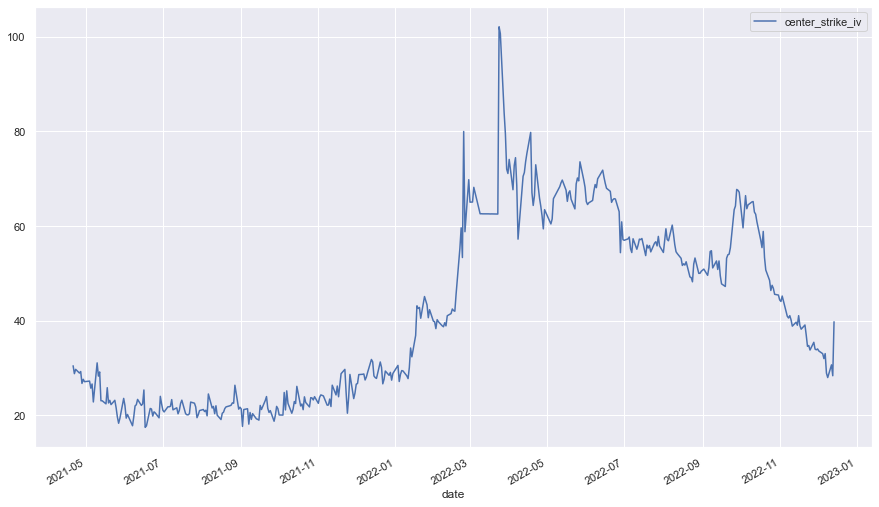

In [26]:
volas.drop('t', axis = 1)['2000':].plot(legend = True, figsize = (15, 9))
plt.show()

Значения соответствуют объективно наблюдавшимся.

Выведем совместно график подразумеваемой и реализованной волатильностей.

In [27]:
v1 = volas.dropna()

In [28]:
v2 = fut.dropna()

In [29]:
v1, v2 = v1.align(v2, join='inner', axis = 0)

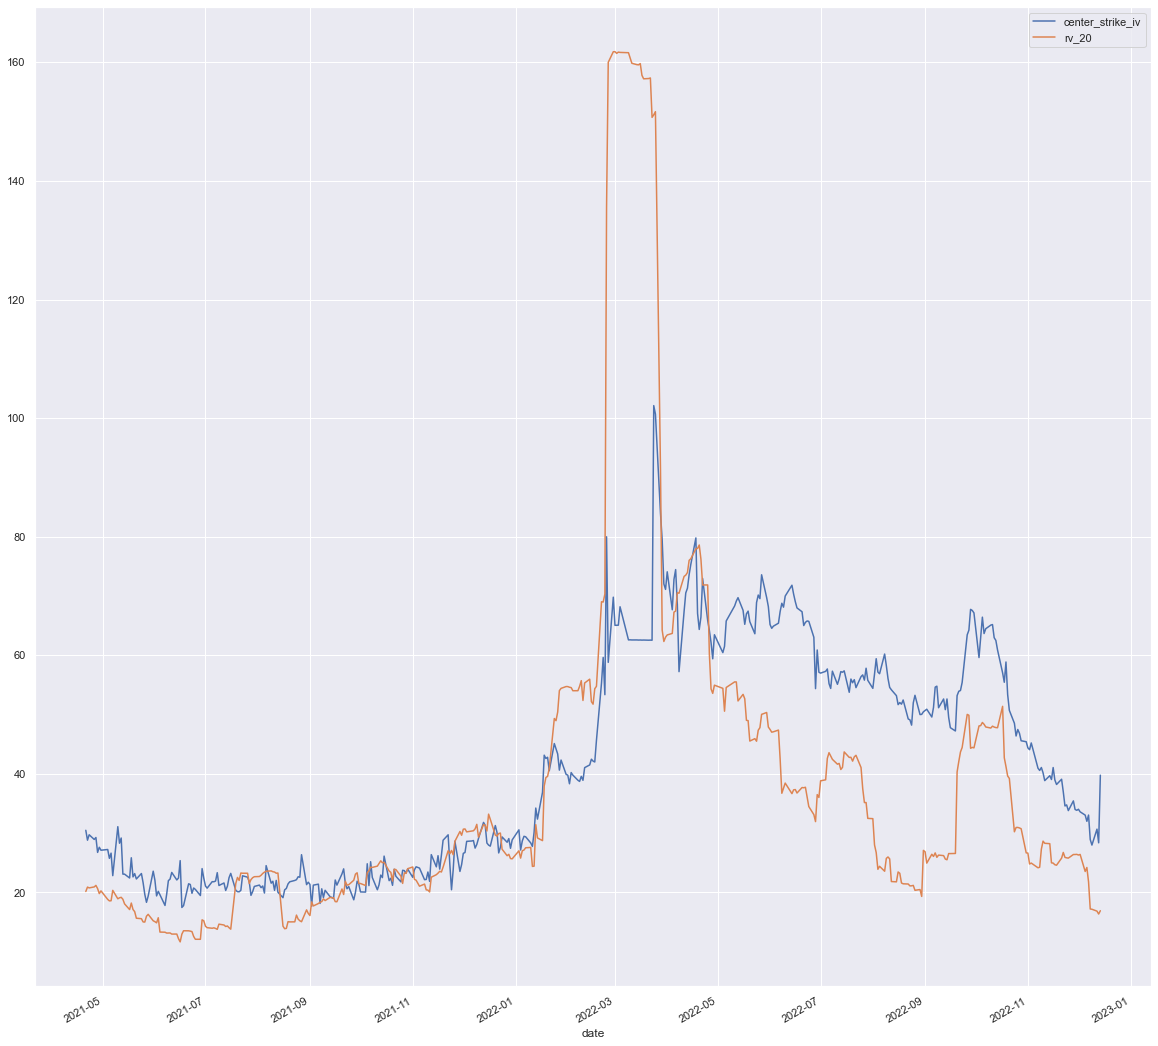

In [30]:
plt.figure(figsize = (20, 20))
v1['center_strike_iv'].plot(legend = True)
v2['rv_20'].plot(legend = True)
plt.show()